In [1]:
# devel clustering from features

In [2]:
import numpy as np
import leidenalg
import igraph
import h5py
from MulticoreTSNE import MulticoreTSNE

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors, kneighbors_graph

In [3]:
z = np.load('z_L2.npy')
print(z.shape)
print((z.sum(axis=0)==0).sum())

(146791, 256)
44


In [4]:
zidx = np.sort(np.random.choice(z.shape[0], 15000, replace=False))
zsample = z[zidx]
tsne = MulticoreTSNE(n_jobs=8, verbose=2)
emb = tsne.fit_transform(zsample)
print(emb.shape)

(15000, 2)


In [5]:
adj = kneighbors_graph(zsample, n_neighbors=10, n_jobs=8)
sources, targets = adj.nonzero()
edgelist = zip(sources.tolist(), targets.tolist())
nn_graph = igraph.Graph(edgelist)

part = leidenalg.find_partition(nn_graph, leidenalg.RBConfigurationVertexPartition,
                                resolution_parameter=0.6)

groups = np.array(part.membership)
print(groups.shape)

(15000,)


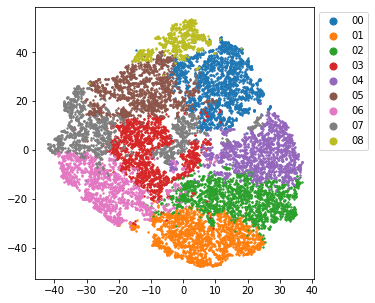

In [6]:
plt.figure(figsize=(5,5))
for g in np.unique(groups):
    i = groups==g
    plt.scatter(emb[i,0], emb[i,1], s=2, label=f'{g:02d}')
plt.legend(bbox_to_anchor=(1,1), markerscale=5)

In [13]:
h5f = h5py.File("/dev/shm/dataset.hdf5", "r")

In [14]:
print(h5f.keys())
print(h5f['cells'].keys())
print(h5f['meta'].keys())
print(h5f['intensity'].keys())

<KeysViewHDF5 ['cells', 'intensity', 'meta']>
<KeysViewHDF5 ['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']>
<KeysViewHDF5 ['Cell_IDs', 'channel_names', 'coordinates', 'nuclear_masks']>
<KeysViewHDF5 ['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']>


In [42]:
coords = h5f['meta/coordinates'][:]
coords = coords[zidx]
# Flip the y coords
coords[:,1] = -coords[:,1]

In [60]:
def plot_embedding(emb, values, title=None, categorical=False, size=2, ax=None, figsize=(3,3),
                   hideticks=True):
    """
    Scatter plot some cells

    Args:
        emb (np.float32): (n_cells x 2)
        values (np.float32, np.int): (n_cells)
        categorical (bool): Whether to treat values as categorical (i.e. groups)
        ax (matplotlib.pyplot.Axes): axis to use

    Returns:
        -
    """
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
    if not categorical:
        srt = np.argsort(values)
        emb = emb[srt,:]
        values = values[srt]
        sp = ax.scatter(emb[:,0], emb[:,1], s=size, c=values)
        plt.colorbar(sp, ax=ax)
    
    else:
        for v in np.unique(values):
            ix = values == v
            ax.scatter(emb[ix, 0], emb[ix, 1], s=size, label=v)
        plt.legend(bbox_to_anchor=(1,1))
    
    if title is not None:
        ax.set_title(title)
    if hideticks:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

In [37]:
channel_names = [b.decode('UTF-8') for b in h5f['meta/channel_names'][:]]

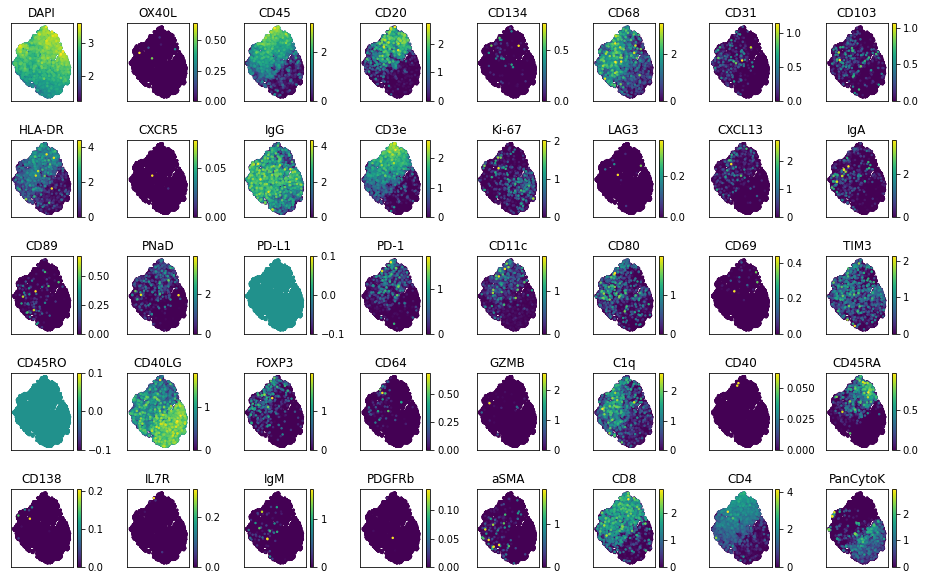

In [48]:
fig, axs = plt.subplots(5,8, figsize=(16,10), gridspec_kw=dict(hspace=0.5, wspace=0.5))
for channel, ax in zip(channel_names, axs.ravel()):
    # Its faster to load the whole thing then subset?
    color_vals = h5f[f'intensity/{channel}'][:]
    color_vals = color_vals[zidx]
    plot_embedding(emb, np.log1p(color_vals), title=channel, ax=ax)

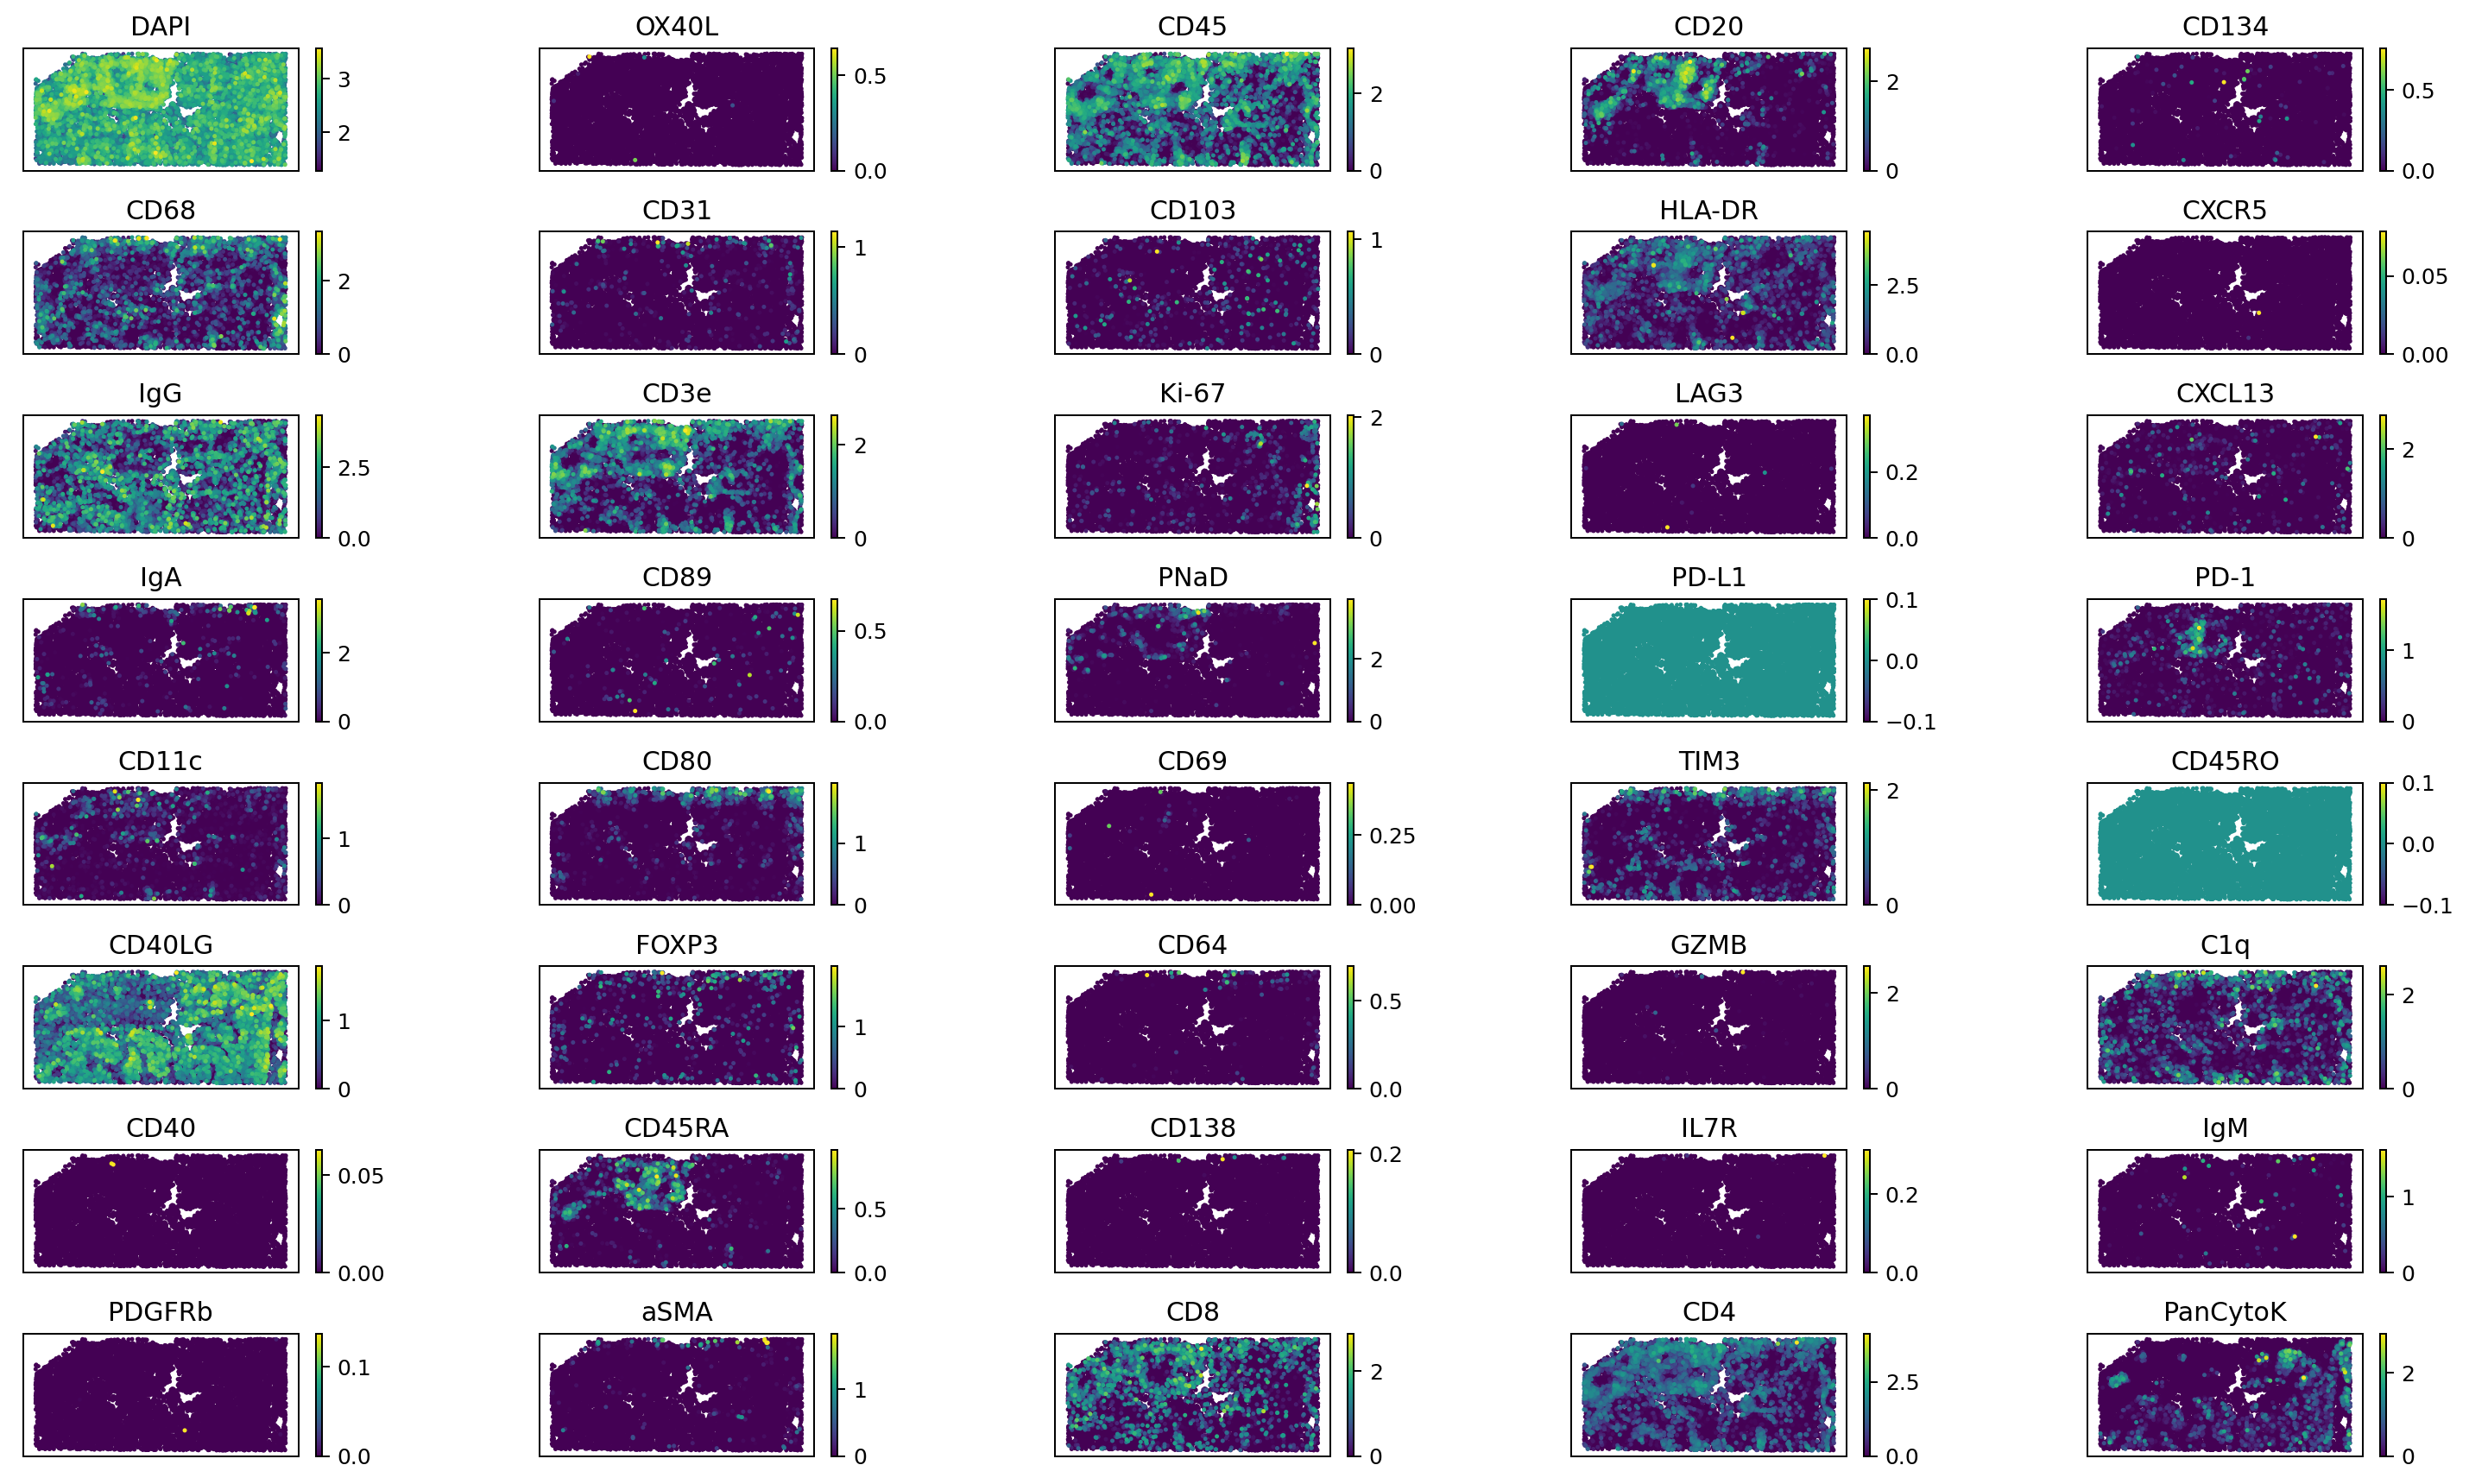

In [50]:
fig, axs = plt.subplots(8,5, figsize=(20, 12), dpi=180, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for channel, ax in zip(channel_names, axs.ravel()):
    # Its faster to load the whole thing then subset?
    color_vals = h5f[f'intensity/{channel}'][:]
    color_vals = color_vals[zidx]
    plot_embedding(coords, np.log1p(color_vals), title=channel, size=1, ax=ax)

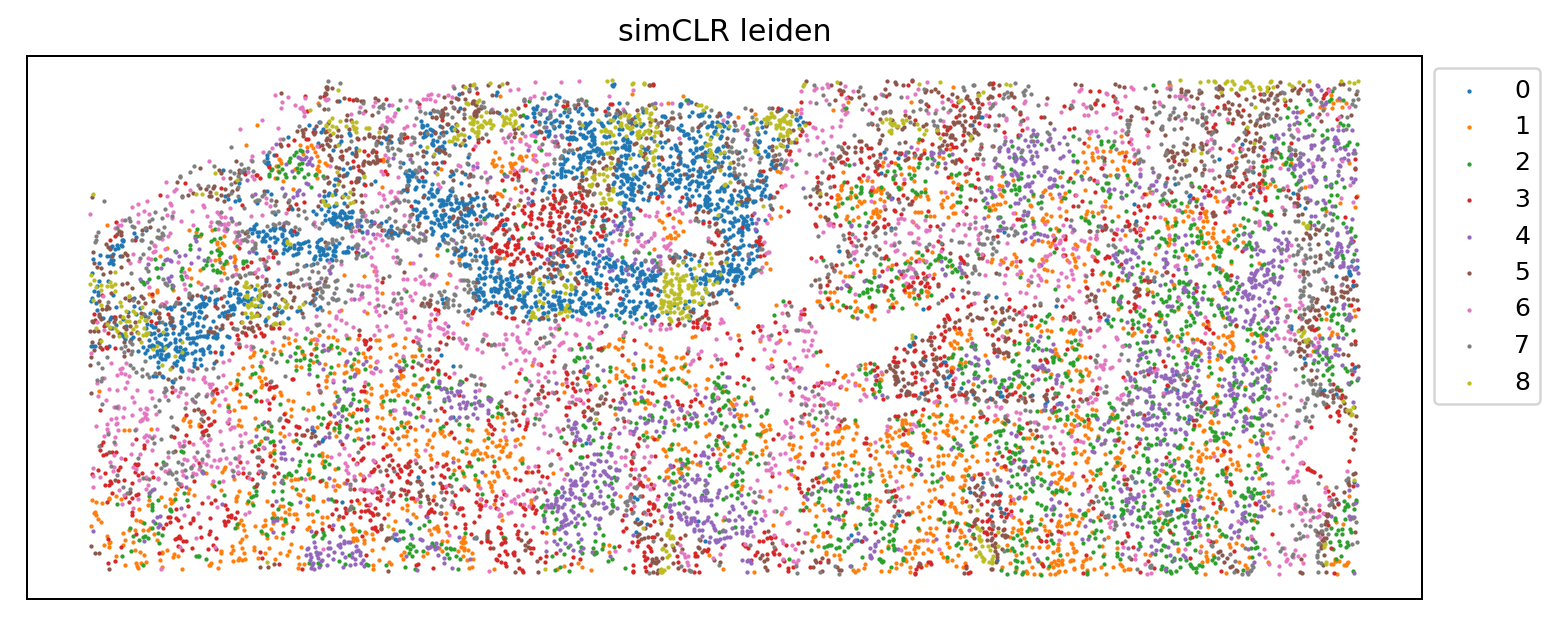

In [63]:
plt.figure(figsize=(10,4), dpi=180)
ax = plt.gca()
plot_embedding(coords, groups, categorical=True, title='simCLR leiden', size=0.5, ax=ax)

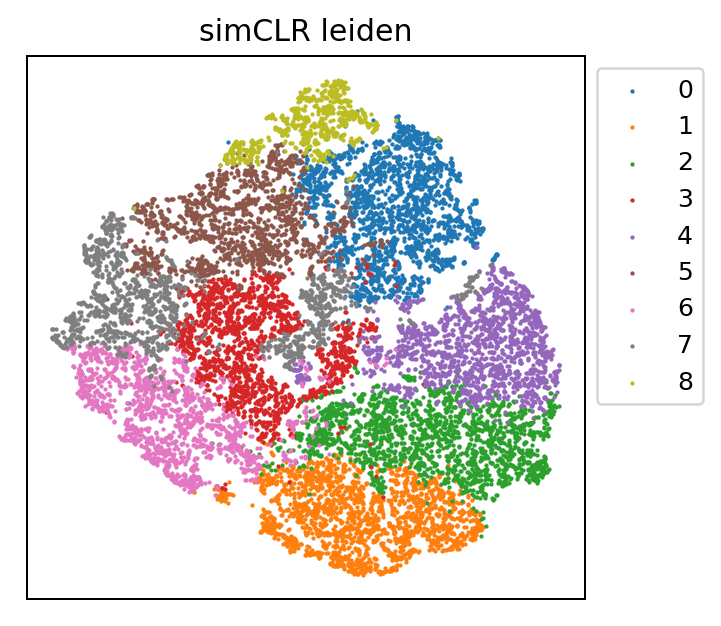

In [64]:
plt.figure(figsize=(4,4), dpi=180)
ax = plt.gca()
plot_embedding(emb, groups, categorical=True, title='simCLR leiden', size=0.5, ax=ax)

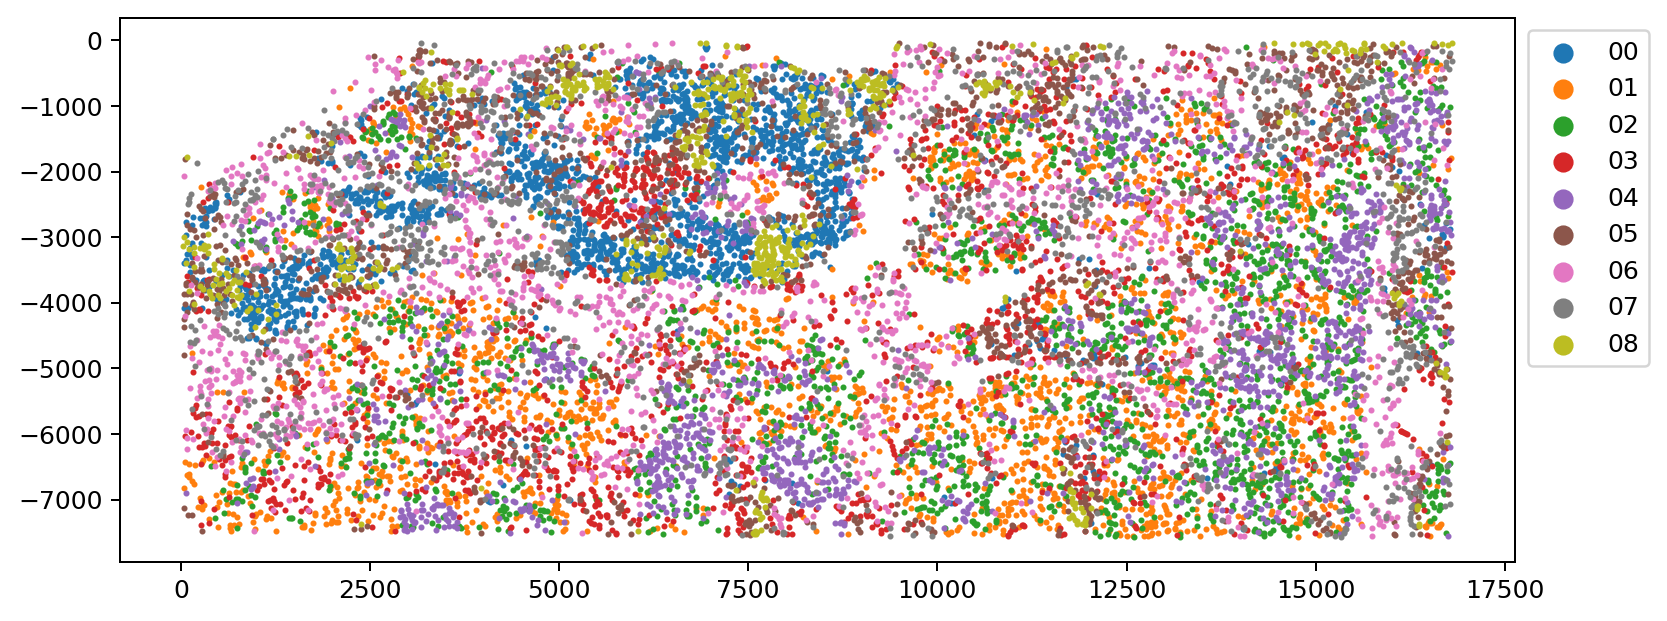

In [11]:
plt.figure(figsize=(10,4), dpi=180)
for g in np.unique(groups):
    i = groups==g
    plt.scatter(coords[i,0], -coords[i,1], s=2, label=f'{g:02d}')
plt.legend(bbox_to_anchor=(1,1), markerscale=5)

In [65]:
h5f.close()